In [1]:
import numpy as np
from pytorch_lightning import seed_everything, LightningModule, Trainer
from sklearn.utils import class_weight
import torch.nn as nn
import torch
from torch.utils.data.dataloader import DataLoader
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,LearningRateMonitor
from torch.optim.lr_scheduler import CyclicLR, ReduceLROnPlateau,CosineAnnealingWarmRestarts,OneCycleLR,LambdaLR

import torchvision
from sklearn.metrics import classification_report,f1_score,accuracy_score
import matplotlib.pyplot as plt

In [2]:
import albumentations as A

from albumentations.pytorch import ToTensorV2

aug= A.Compose([
            A.Resize(256, 256),
            A.CenterCrop(224,224),
            A.Normalize(mean=(0,0,0), std=(1, 1, 1)),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [3]:
#https://github.com/hysts/pytorch_cutmix
def cutmix(batch, alpha):
    data, targets = batch

    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(alpha, alpha)

    image_h, image_w = data.shape[2:]
    cx = np.random.uniform(0, image_w)
    cy = np.random.uniform(0, image_h)
    w = image_w * np.sqrt(1 - lam)
    h = image_h * np.sqrt(1 - lam)
    x0 = int(np.round(max(cx - w / 2, 0)))
    x1 = int(np.round(min(cx + w / 2, image_w)))
    y0 = int(np.round(max(cy - h / 2, 0)))
    y1 = int(np.round(min(cy + h / 2, image_h)))

    data[:, :, y0:y1, x0:x1] = shuffled_data[:, :, y0:y1, x0:x1]
    targets = (targets, shuffled_targets, lam)

    return data, targets


class CutMixCollator:
    def __init__(self, alpha):
        self.alpha = alpha

    def __call__(self, batch):
        batch = torch.utils.data.dataloader.default_collate(batch)
        batch = cutmix(batch, self.alpha)
        return batch
class CutMixCriterion:
    def __init__(self, reduction='mean'):
        self.criterion = nn.CrossEntropyLoss(reduction=reduction)

    def __call__(self, preds, targets):
        targets1, targets2, lam = targets
        return lam * self.criterion(
            preds, targets1) + (1 - lam) * self.criterion(preds, targets2)

In [4]:
#https://discuss.pytorch.org/t/using-imagefolder-random-split-with-multiple-transforms/79899/4
from torch.utils.data import DataLoader, Dataset
img_size=224
class MyLazyDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        x=self.dataset[index][0]
        y=self.dataset[index][1]
        if self.transform:
            #x = self.transform(x)
            x=np.array(x)
            x=self.transform(image=x)['image']
        return x, y
    
    def __len__(self):
        return len(self.dataset)

In [5]:
collator = CutMixCollator(1.0)

In [6]:
train_split=torchvision.datasets.ImageFolder('splited_dataset/train')
ds=DataLoader(MyLazyDataset(train_split,aug), batch_size = 16, 
                          num_workers=0,shuffle=False,collate_fn=collator,)
batch=next(iter(ds))


In [7]:
image=batch[0]
t1,t2,lam=batch[1]

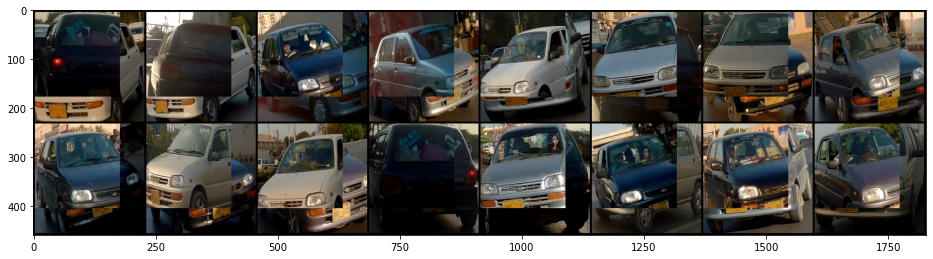

In [8]:
from torch.utils.data.dataloader import DataLoader
import torchvision
import matplotlib.pyplot as plt
plt.figure(figsize=(16,16))
grid_img=torchvision.utils.make_grid(image,8,4)
plt.imshow(grid_img.permute(1, 2, 0))

In [9]:
model_name='efficientnetv2_rw_s'

In [10]:
import timm
import torchmetrics
import torchvision.models as models
class OurModel(LightningModule):
    def __init__(self):
        super(OurModel,self).__init__()
        #architecute
        self.train_split=torchvision.datasets.ImageFolder('splited_dataset/train')
        self.test_split=torchvision.datasets.ImageFolder('splited_dataset/test')
        print(len(self.train_split), 'images in ',len(self.train_split.classes),' classes')
        self.model =  timm.create_model(model_name,pretrained=True)
        self.fc1=nn.Linear(1000,500)
        self.relu=nn.ReLU()
        self.fc2= nn.Linear(500,len(self.train_split.classes))
        #parameters
        self.lr=1e-3
        self.batch_size=48
        self.numworker=0
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()
        self.criterion=CutMixCriterion()
        self.val_criterion=nn.CrossEntropyLoss()
        
        self.trainacc,self.valacc=[],[]
        self.trainloss,self.valloss=[],[]
    def forward(self,x):
        x= self.model(x)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        return x

    def configure_optimizers(self):
        opt=torch.optim.AdamW(params=self.parameters(),lr=self.lr )
        return opt

    def train_dataloader(self):
        return DataLoader(MyLazyDataset(self.train_split,aug), batch_size = self.batch_size, 
                          num_workers=self.numworker,shuffle=True,collate_fn=collator)

    def training_step(self,batch,batch_idx):
        image,label=batch
        target1,target2,lam=label
        out = self(image)
        loss=self.criterion(out,label)
        return {'loss':loss}

    def training_epoch_end(self, outputs):
        loss=torch.stack([x["loss"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        #acc=torch.stack([x["acc"] for x in outputs]).mean().detach().cpu().numpy().round(2)
       # print('training loss accuracy ',loss, acc)
        #self.trainacc.append(acc)
        self.trainloss.append(loss)
        self.log('train_loss', loss)
        #self.log('train_acc', acc)
        
    def val_dataloader(self):
        ds=DataLoader(MyLazyDataset(self.test_split,aug), batch_size = self.batch_size,
                      num_workers=self.numworker, shuffle=False)
        return ds

    def validation_step(self,batch,batch_idx):
        image,label=batch
        out=self(image)
        loss=self.val_criterion(out,label)
        acc=self.val_acc(out,label.long())
        return {'loss':loss,'acc':acc}

    def validation_epoch_end(self, outputs):
        loss=torch.stack([x["loss"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        acc=torch.stack([x["acc"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        self.valacc.append(acc)
        self.valloss.append(loss)
        print('validation loss accuracy ',loss, acc)
        self.log('val_loss', loss)
        self.log('val_acc', acc)


    def test_dataloader(self):
        return DataLoader(MyLazyDataset(self.test_split,aug), batch_size = self.batch_size,num_workers=self.numworker, shuffle=False)

    def test_step(self,batch,batch_idx):
        image,label=batch
        out=self(image)
        loss=self.val_criterion(out,label.long())
        return {'loss':loss,'pred':out,'label':label}
    def test_epoch_end(self, outputs):
        loss=torch.stack([x["loss"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        pred=torch.cat([x["pred"] for x in outputs]).detach().cpu().numpy()
        label=torch.cat([x["label"] for x in outputs]).detach().cpu().numpy()
        pred=np.argmax(pred,1)
        print(classification_report(label,pred,target_names=self.train_split.class_to_idx))
        print('accuracy',accuracy_score(label,pred))
        print('f1 score',f1_score(label,pred,average='macro'))



In [11]:

from torch.nn.modules.module import Module
class CutMixCrossEntropyLoss(Module):
    def __init__(self, size_average=True):
        super().__init__()
        self.size_average = size_average

    def forward(self, input, target):
        if len(target.size()) == 1:
            target = torch.nn.functional.one_hot(target, num_classes=input.size(-1))
            #target = target.float()
        return self.cross_entropy(input, target, self.size_average)
    
    def cross_entropy(self,input, target, size_average=True):
        """ Cross entropy that accepts soft targets
        Args:
             pred: predictions for neural network
             targets: targets, can be soft
             size_average: if false, sum is returned instead of mean
        Examples::
            input = torch.FloatTensor([[1.1, 2.8, 1.3], [1.1, 2.1, 4.8]])
            input = torch.autograd.Variable(out, requires_grad=True)
            target = torch.FloatTensor([[0.05, 0.9, 0.05], [0.05, 0.05, 0.9]])
            target = torch.autograd.Variable(y1)
            loss = cross_entropy(input, target)
            loss.backward()
        """
        logsoftmax = torch.nn.LogSoftmax(dim=1)
        if size_average:
            return torch.mean(torch.sum(-target * logsoftmax(input), dim=1))
        else:
            return torch.sum(torch.sum(-target * logsoftmax(input), dim=1))

In [12]:
#read api from trext file
with open('api.txt') as f:
    api=f.readline()

In [13]:

from neptune.new.integrations.pytorch_lightning import NeptuneLogger
seed_everything(0)
neptune_logger = NeptuneLogger(
            api_key=api,
            project='mrtictac96/pakvehicle', 
            close_after_fit=False,
            name='cutmix_effnet',
            tags='cutmix_effnet'
        )

Global seed set to 0


In [14]:
es=EarlyStopping(monitor="val_loss",patience=10, verbose=True)
seed_everything(0)
lr_monitor = LearningRateMonitor(logging_interval='epoch')

model = OurModel()
trainer = Trainer(max_epochs=50, auto_lr_find=False, auto_scale_batch_size=False,
                  deterministic=True,
                  gpus=-1,precision=16,
                  accumulate_grad_batches=8,
                  stochastic_weight_avg=True,
                  progress_bar_refresh_rate=0,
                  log_every_n_steps=5,
                 # callbacks=[es,lr_monitor],
                  logger=neptune_logger
                  )
#trainer.tune(model)



Global seed set to 0


3106 images in  48  classes


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


In [15]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\anaconda3\lib\site-packages\neptune\new\internal\utils\git.py:34: UserWarning: GitPython could not be initialized
  warnings.warn("GitPython could not be initialized")


https://app.neptune.ai/mrtictac96/pakvehicle/e/PAKVEHICLE-62
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.



  | Name          | Type             | Params
---------------------------------------------------
0 | model         | EfficientNet     | 23.9 M
1 | fc1           | Linear           | 500 K 
2 | relu          | ReLU             | 0     
3 | fc2           | Linear           | 24.0 K
4 | train_acc     | Accuracy         | 0     
5 | val_acc       | Accuracy         | 0     
6 | val_criterion | CrossEntropyLoss | 0     
---------------------------------------------------
24.5 M    Trainable params
0         Non-trainable params
24.5 M    Total params
97.863    Total estimated model params size (MB)
C:\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
Global seed set to 0


validation loss accuracy  3.9 0.0


C:\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


validation loss accuracy  1.9 0.56
validation loss accuracy  1.05 0.78
validation loss accuracy  0.82 0.83
validation loss accuracy  0.68 0.89
validation loss accuracy  0.41 0.92
validation loss accuracy  0.63 0.92
validation loss accuracy  0.39 0.93
validation loss accuracy  0.43 0.93
validation loss accuracy  0.36 0.93
validation loss accuracy  0.43 0.92
validation loss accuracy  0.37 0.94
validation loss accuracy  0.34 0.94
validation loss accuracy  0.36 0.93
validation loss accuracy  0.35 0.94
validation loss accuracy  0.29 0.94
validation loss accuracy  0.28 0.95
validation loss accuracy  0.35 0.95
validation loss accuracy  0.29 0.95
validation loss accuracy  0.26 0.95
validation loss accuracy  0.3 0.95
validation loss accuracy  0.25 0.95
validation loss accuracy  0.25 0.95
validation loss accuracy  0.26 0.95
validation loss accuracy  0.27 0.95
validation loss accuracy  0.27 0.94
validation loss accuracy  0.24 0.95
validation loss accuracy  0.28 0.95
validation loss accuracy  0.24

In [16]:
torch.save(model.state_dict(), './weights/cutmix_effnet.pt')

In [17]:
trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


                        precision    recall  f1-score   support

          Daiatsu_Core       1.00      0.95      0.97        20
         Daiatsu_Hijet       0.83      1.00      0.91        10
          Daiatsu_Mira       1.00      1.00      1.00        20
                FAW_V2       1.00      1.00      1.00         7
               FAW_XPV       1.00      1.00      1.00         6
             Honda_BRV       0.86      1.00      0.92         6
     Honda_City_aspire       1.00      0.96      0.98        26
           Honda_Grace       0.60      0.60      0.60         5
          Honda_Vezell       1.00      1.00      1.00         9
       Honda_city_1994       0.86      0.86      0.86         7
       Honda_city_2000       0.88      0.88      0.88        17
      Honda_civic_1994       1.00      1.00      1.00         4
      Honda_civic_2005       0.88      0.88      0.88         8
      Honda_civic_2007       1.00      1.00      1.00        18
      Honda_civic_2015       0.75      

[{}]

In [18]:
neptune_logger.experiment.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 21 operations to synchronize with Neptune. Do not kill this process.


All 21 operations synced, thanks for waiting!


# grad cam

In [20]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
#target_layer = model.model.features.denseblock4.denselayer16
cam = GradCAMPlusPlus(model=model, target_layer=target_layer, use_cuda='cuda')
model.load_state_dict(torch.load('./weights/cutmix_effnet.pt'))

<All keys matched successfully>

In [21]:
test_aug= A.Compose([
            A.Resize(256, 256),
            A.CenterCrop(224,224),
            A.Normalize(mean=(0,0,0), std=(1, 1, 1)),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [22]:
from PIL import Image
img=Image.open('./images/test_car_1.jpg')
img=test_aug(image=np.array(img))['image']
img=img.unsqueeze(0)
print(img.shape)

torch.Size([1, 3, 224, 224])


In [23]:
model=model.cuda()
pred=model(img.cuda())
pred=torch.argmax(pred,1)

In [24]:
pred=int(pred.cpu().numpy())
pred_class=model.train_split.classes[pred]
pred_class

'Toyota_Vigo'

In [30]:
camout = cam(input_tensor=img, target_category=18,aug_smooth=True)

In [31]:
new_image=np.moveaxis(img.squeeze(0).numpy(),0,2)
new_image.shape

(224, 224, 3)

In [32]:
output=show_cam_on_image(new_image , camout.squeeze(0))
output.shape

(224, 224, 3)

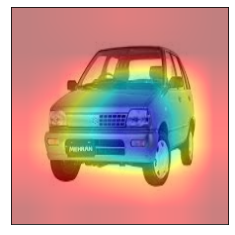

In [33]:
plt.imshow(output)
plt.xticks([])
plt.yticks([])
plt.savefig('./images/cam/resnet/cutmix.png',bbox_inches='tight')